In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Value:
    
    def __init__(self, data, _children = (), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = np.zeros_like(self.data, dtype = np.float64)
    
    def __add__(self, other):
        if(isinstance(other, (int, float))):
            other = Value(np.array(other))

        a = self.data.shape[0]
        b = 1
        if(len(self.data.shape) > 1):
            b = self.data.shape[1]
        c = other.data.shape[0]
        d = 1
        if(len(other.data.shape) > 1):
            d = other.data.shape[1]
        
        assert ((a == c) or (b == d)), "Can't add these matrices"
        out = Value(self.data + other.data, (self, other), '+')
        if a == c:
            if b != d:
                assert d == 1 or b == 1, "Can't broadcast these matrices"
        
        if d == b:
            if c != a:
                assert c == 1 or b == 1, "Can't broadcast these matrices"
        
        
        def _backward():
            other_grad = out.grad
            self_grad = out.grad
            if(a == c):
                if b != d:
                    if d == 1:
                        other_grad = np.sum(out.grad, axis = 1, keepdims = True)
                    else:
                        self_grad = np.sum(out.grad, axis = 1, keepdims = True)

            if(d == b):
                if c != a:
                    if c == 1:
                        other_grad = np.sum(out.grad, axis = 0, keepdims = True)
                    else:
                        self_grad = np.sum(out.grad, axis = 0, keepdims = True)
                    
            self.grad += self_grad
            other.grad += other_grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        if isinstance(other, np.ndarray):
            other = Value(other)
        return self + (-other)
    
    
    def __mul__(self, other):
        if isinstance(other, (int, float)):
            other = Value(np.array([[other]]))
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            grad_add = other.data * out.grad
            if self.data.shape[1] == 1:
                grad_add = np.sum(grad_add, axis = 1, keepdims = True)
            
            if self.data.shape[0] == 1:
                grad_add = np.sum(grad_add, axis = 0, keepdims = True)
                
            self.grad += grad_add
            
            grad_add = self.data * out.grad
            if other.data.shape[1] == 1:
                grad_add = np.sum(grad_add, axis = 1, keepdims = True)
            
            if other.data.shape[0] == 1:
                grad_add = np.sum(grad_add, axis = 0, keepdims = True)
            
            other.grad += grad_add
        out._backward = _backward
        return out
    
    def __neg__(self):
        return (self * -1) 
    
    def __matmul__(self, other): # self @ other == w @ x
        a, b = self.data.shape
        c, d = other.data.shape
        assert (b == c) or (a == d), "Can't multiply matrices"
        if b != c:
            return other @ self
        
        out = Value(self.data @ other.data, (self, other), '@')
        
        def _backward():
            self.grad += out.grad @ other.data.T
            other.grad += self.data.T @ out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * self.data**(other - 1)
        out._backward = _backward
        return out
    
    
    def tanh(self):
        out = Value(np.tanh(self.data), (self, ), 'tanh')
        
        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        
        out._backward = _backward
        return out
    
    def sum(self):
        out = Value(np.sum(self.data), (self, ), 'sigma')
        
        def _backward():
            # for each element of the gradient array,
            # broadcast and add the out grad
            self.grad += out.grad
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()

In [7]:
a = Value(np.arange(16).reshape(4, 4))
b = Value(np.arange(4).reshape(4, 1))
c = b * a
c

Value(data=[[ 0  0  0  0]
 [ 4  5  6  7]
 [16 18 20 22]
 [36 39 42 45]], grad=[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]])

In [8]:
c.backward()
b, a

(Value(data=[[0]
  [1]
  [2]
  [3]], grad=[[ 6.]
  [22.]
  [38.]
  [54.]]),
 Value(data=[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]], grad=[[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [2. 2. 2. 2.]
  [3. 3. 3. 3.]]))

In [28]:
class Layer:
    def __init__(self, nin, nout):
        self.w = Value(np.random.uniform(-1, 1, size = (nout, nin)), label = 'w')
        self.b = Value(np.random.uniform(-1, 1, size = (nout, 1)), label = 'b')
        
    def __call__(self, x):
        out_value = self.w @ x + self.b
        p = out_value.tanh()
        return p
    
    def params(self):
        return [self.w, self.b]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.params())
        return params
    
    def zero_grad(self):
        for layer in self.layers:
            layer.w.grad = np.zeros_like(layer.w.grad)
            layer.b.grad = np.zeros_like(layer.b.grad)
            
    
    def train(self, x, y, epochs = 10000, output_period = 100):
        data = []
        for k in range(epochs):
            yout = n(x)
            loss = ((yout - y_pred)**2).sum()
            loss.backward()
            
            params = self.parameters()
            lr = 0.001
            for param in params:
                param.data -= lr * param.grad
            self.zero_grad()
            if k % output_period == 0:
                data.append([k, loss.data])
        return np.array(data)

In [29]:
n = MLP(3, [4, 4, 1])

In [30]:
xs = Value(np.array([
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]).T)
y_pred = Value(np.array([[1.0, -1.0, -1.0, 1.0]]))

In [31]:
history = n.train(xs, y_pred, 1000, 1)

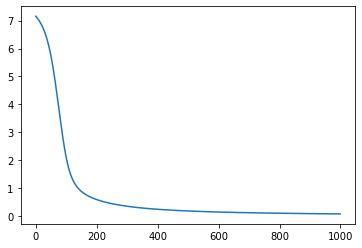

In [32]:
plt.plot(history[:, 0], history[:, 1])
# plt.scatter(history[:, 0], history[:, 1], s = 1, marker = 'x')

In [33]:
n(xs)

Value(data=[[ 0.88646749 -0.90568285 -0.84789133  0.83438435]], grad=[[0. 0. 0. 0.]])

In [34]:
n.parameters()

[Value(data=[[ 0.15883786 -0.91934224  1.00932881]
  [ 0.92316565  0.06638625 -0.25360066]
  [-0.6039634  -0.24525947 -0.74957933]
  [ 0.88032234  0.01768619  0.46528116]], grad=[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]),
 Value(data=[[ 0.87300617]
  [ 0.29004812]
  [-0.97152182]
  [-0.53054597]], grad=[[0.]
  [0.]
  [0.]
  [0.]]),
 Value(data=[[-1.15349423  0.39266513 -0.02232781 -0.74934566]
  [-0.18002749  0.92927621 -0.77266283  0.44093955]
  [-0.59761804  0.42947167  0.21083124 -0.49926821]
  [ 0.95477197  0.72045248  0.03831891 -0.9123852 ]], grad=[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]),
 Value(data=[[ 0.02480233]
  [ 0.11607761]
  [-0.76521404]
  [ 0.09183052]], grad=[[0.]
  [0.]
  [0.]
  [0.]]),
 Value(data=[[ 1.4228692  -0.26971547 -0.02620481 -0.39846301]], grad=[[0. 0. 0. 0.]]),
 Value(data=[[0.2756045]], grad=[[0.]])]

In [35]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        pp = n.data
        if isinstance(n.data, np.ndarray):
            pp = n.data.shape
        ppg = n.grad
        if isinstance(n.grad, np.ndarray):
            ppg = n.grad.shape
        pp = str(pp)
        ppg = str(ppg)
        dot.node(name = uid, label = "{ %s | data.s %s, grad.s : %s }" % (n.label, pp, ppg), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot